# Interpretable models by design

## Linear Models

In [ ]:
# download data from:
# https://christophm.github.io/interpretable-ml-book/data.html#bike-data

import pandas as pd
bike_rental = pd.read_csv("/content/bike-sharing-daily.csv")
bike_rental.head()


,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [ ]:
# Some cleaning according to the authors' descrition
# prompt: 使用 DataFrame bike_rental: info and I removed one day where the humidity was measured as 0, and the first two days due to missing count data two days before (cnt_2d_bfr). All in all, the processed data contains 728 days.

# Filter out rows where humidity is 0
bike_rental = bike_rental[bike_rental['hum'] != 0]

# Filter out the first two days (instant 1 and 2)
bike_rental = bike_rental[bike_rental['instant'] > 2]

# Display the information of the modified dataframe
bike_rental.info()

<class 'pandas.core.frame.DataFrame'>
Index: 728 entries, 2 to 730
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     728 non-null    int64  
 1   dteday      728 non-null    object 
 2   season      728 non-null    int64  
 3   yr          728 non-null    int64  
 4   mnth        728 non-null    int64  
 5   holiday     728 non-null    int64  
 6   weekday     728 non-null    int64  
 7   workingday  728 non-null    int64  
 8   weathersit  728 non-null    int64  
 9   temp        728 non-null    float64
 10  atemp       728 non-null    float64
 11  hum         728 non-null    float64
 12  windspeed   728 non-null    float64
 13  casual      728 non-null    int64  
 14  registered  728 non-null    int64  
 15  cnt         728 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 96.7+ KB


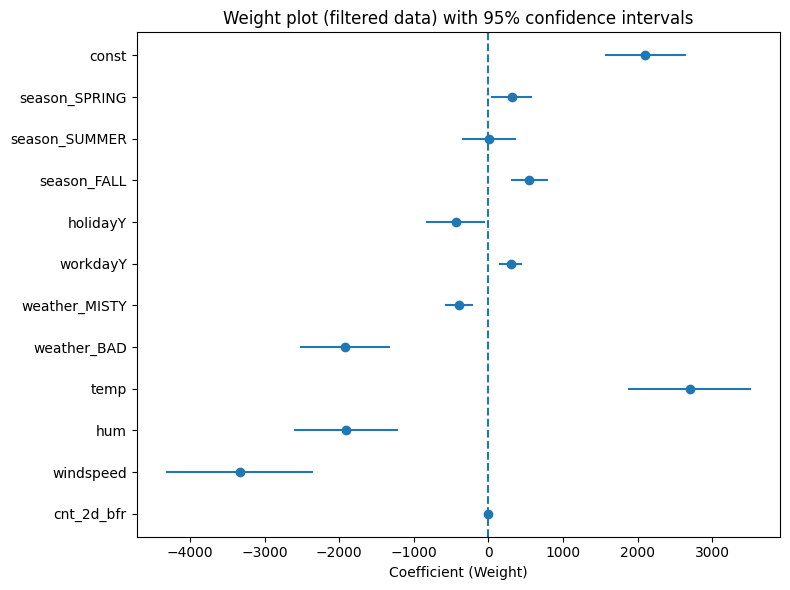

In [ ]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# 1. Load & basic filters ----------------------------------------------------
df = bike_rental.copy()

# keep rows with positive humidity and instant > 2
df = df[(df["hum"] != 0) & (df["instant"] > 2)].copy()

# 2. Create 2‑day lag of cnt -------------------------------------------------
df["cnt_2d_bfr"] = df["cnt"].shift(2)

# Drop rows with NaN due to lag
df = df.dropna(subset=["cnt_2d_bfr"])

# 3. Feature engineering ----------------------------------------------------
season_map  = {1: "WINTER", 2: "SPRING", 3: "SUMMER", 4: "FALL"}
weather_map = {1: "CLEAR",  2: "MISTY",  3: "BAD",    4: "HORRIBLE"}
df["season_name"]  = df["season"].map(season_map)
df["weather_name"] = df["weathersit"].map(weather_map)
df["holidayY"] = (df["holiday"] == 1).astype(int)
df["workdayY"] = (df["workingday"] == 1).astype(int)

# Desired dummy columns (will fill with 0 if absent)
season_cats  = ["SPRING", "SUMMER", "FALL"]
weather_cats = ["MISTY", "BAD"]

d_season  = pd.get_dummies(df["season_name"],  prefix="season",  dtype=int)\
               .reindex(columns=[f"season_{c}"  for c in season_cats],  fill_value=0)
d_weather = pd.get_dummies(df["weather_name"], prefix="weather", dtype=int)\
               .reindex(columns=[f"weather_{c}" for c in weather_cats], fill_value=0)

# 4. Assemble X and y -------------------------------------------------------
X = pd.concat([
        d_season,
        df[["holidayY", "workdayY"]],
        d_weather,
        df[["temp", "hum", "windspeed", "cnt_2d_bfr"]]
     ], axis=1)

y = df["cnt"]

# Combine and ensure no NaNs (should be none)
XY = pd.concat([y, X], axis=1).dropna()

y_ = XY["cnt"]
X_ = sm.add_constant(XY.drop(columns="cnt"), prepend=True)

# 5. Run OLS with robust SEs ------------------------------------------------
model = sm.OLS(y_, X_).fit(cov_type="HC1")

# Build weight table
results_df = pd.DataFrame({
    "variable": model.params.index,
    "weight": model.params.values,
    "se": model.bse.values
})
results_df["ci_width"] = 1.96 * results_df["se"]

# 6. Plot -------------------------------------------------------------------
results_df_sorted = results_df.iloc[::-1]  # reverse order for plotting
fig, ax = plt.subplots(figsize=(8, 6))
ax.errorbar(
    results_df_sorted["weight"],
    results_df_sorted["variable"],
    xerr=results_df_sorted["ci_width"],
    fmt="o"
)
ax.axvline(0, linestyle="--")
ax.set_xlabel("Coefficient (Weight)")
ax.set_ylabel("")
ax.set_title("Weight plot (filtered data) with 95% confidence intervals")
plt.tight_layout()
plt.show()


In [ ]:
results_df

,variable,weight,se,ci_width
0,const,2104.237668,275.081785,539.160299
1,season_SPRING,311.535297,138.753019,271.955918
2,season_SUMMER,9.398006,183.393705,359.451661
3,season_FALL,548.471260,126.429510,247.801839
4,holidayY,-439.923196,202.569793,397.036795
5,workdayY,298.451389,80.034621,156.867858
6,weather_MISTY,-394.727202,98.511862,193.083249
7,weather_BAD,-1921.047437,309.304656,606.237125
8,temp,2696.719957,418.651764,820.557456
9,hum,-1908.969256,357.326691,700.360314


## Tree-based interpretability

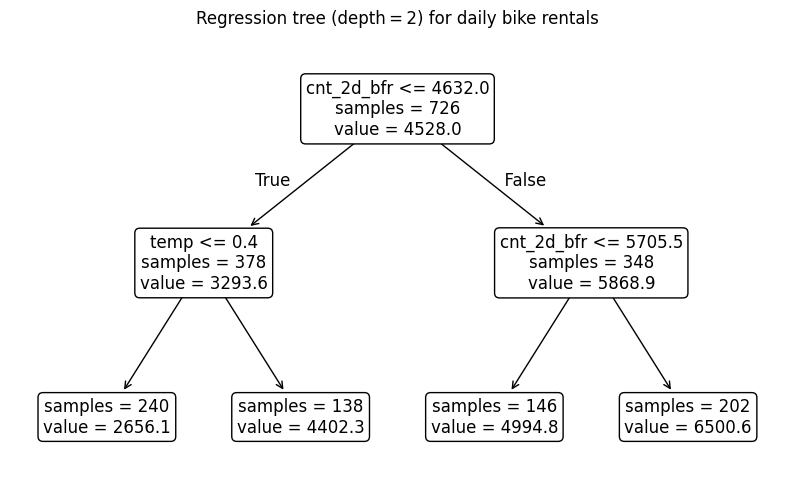

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor, plot_tree


# 1. Load & basic filters ----------------------------------------------------
df = bike_rental.copy()
df = df[(df["hum"] != 0) & (df["instant"] > 2)].copy()
df["cnt_2d_bfr"] = df["cnt"].shift(2)
df = df.dropna(subset=["cnt_2d_bfr"])

X = df[["cnt_2d_bfr", "temp"]]      # only the two strongest drivers
y = df["cnt"]

# ------------------------------------------------------------------
# 2. Build a *very* small regression tree (depth = 2)

tree = DecisionTreeRegressor(max_depth=2, min_samples_leaf=50, random_state=0)
tree.fit(X, y)

plt.figure(figsize=(10, 6))
plot_tree(
    tree,
    feature_names=["cnt_2d_bfr", "temp"],
    filled=False,          # don't enforce any colors
    rounded=True,
    impurity=False,
    precision=1
)
plt.title("Regression tree (depth = 2) for daily bike rentals")
plt.show()

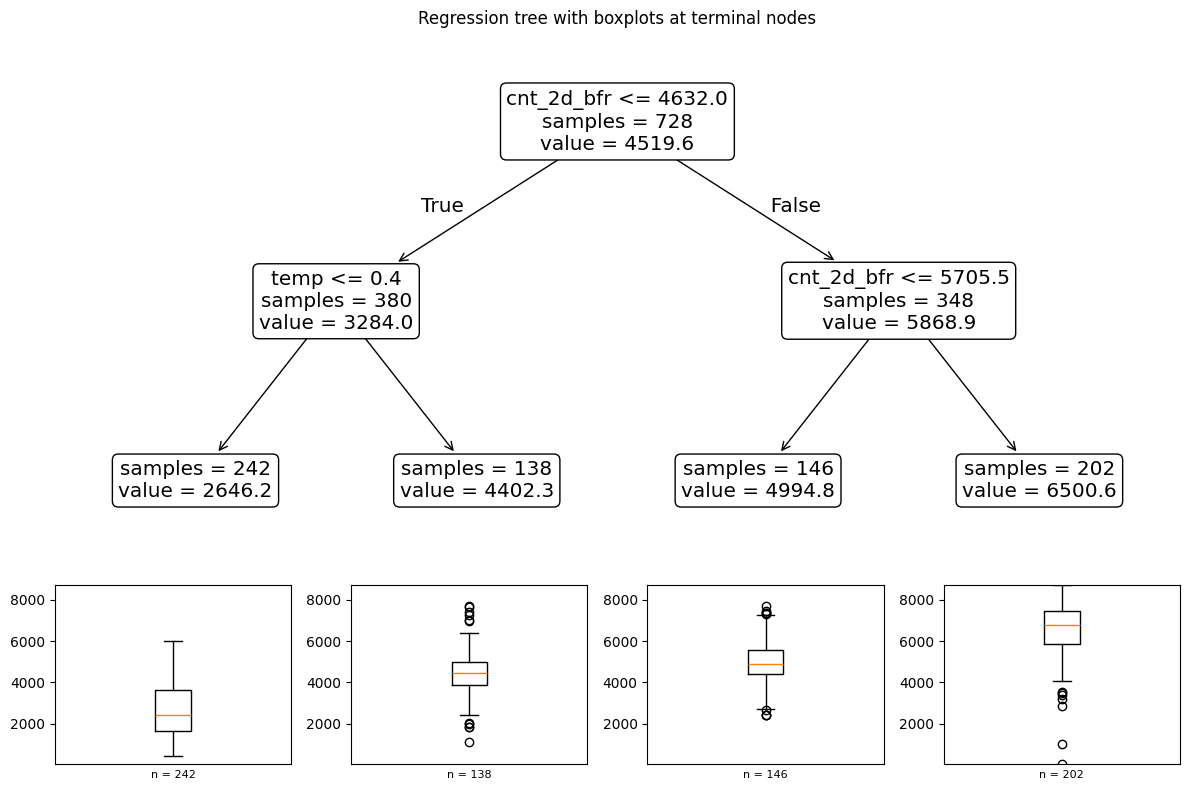

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn.tree import DecisionTreeRegressor, plot_tree, _tree

# ------------------------------------------------------------------
# Load and prep the data  (same filters as before)
# ------------------------------------------------------------------
df = bike_rental.copy()
df = df[(df["hum"] != 0) & (df["instant"] > 2)].copy()
df["cnt_2d_bfr"] = df["cnt"].shift(2)
X = df[["cnt_2d_bfr", "temp"]]
y = df["cnt"]

# Fit a tiny tree (depth 2)
tree = DecisionTreeRegressor(max_depth=2, min_samples_leaf=50, random_state=0)
tree.fit(X, y)

# ------------------------------------------------------------------
# Helper: get leaves in left‑to‑right order
# ------------------------------------------------------------------
def ordered_leaves(tree_):
    children_left  = tree_.children_left
    children_right = tree_.children_right
    ordered = []

    def recurse(node):
        if children_left[node] == _tree.TREE_LEAF:
            ordered.append(node)
        else:
            recurse(children_left[node])
            recurse(children_right[node])

    recurse(0)
    return ordered

leaf_ids = ordered_leaves(tree.tree_)

# Map each sample to its leaf
leaf_assignment = tree.apply(X)
leaf_to_y = {leaf: y[leaf_assignment == leaf] for leaf in leaf_ids}

# ------------------------------------------------------------------
# Build figure with tree on top and boxplots below
# ------------------------------------------------------------------
n_leaves = len(leaf_ids)
fig = plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(2, n_leaves, height_ratios=[3, 1])

# 1) Tree plot spans all columns in the first row
ax_tree = fig.add_subplot(gs[0, :])
plot_tree(
    tree,
    feature_names=["cnt_2d_bfr", "temp"],
    filled=False,
    rounded=True,
    impurity=False,
    precision=1,
    ax=ax_tree
)
ax_tree.set_title("Regression tree with boxplots at terminal nodes")

# 2) Boxplots: one below each leaf
for i, leaf in enumerate(leaf_ids):
    ax_box = fig.add_subplot(gs[1, i])
    ax_box.boxplot(leaf_to_y[leaf], vert=True)
    ax_box.set_xticks([])
    ax_box.set_ylabel("")  # clean
    ax_box.set_xlabel(f"n = {len(leaf_to_y[leaf])}", fontsize=8)
    # Align y‑limits across all boxplots for comparability
    ax_box.set_ylim(y.min(), y.max())

plt.tight_layout()
plt.show()


# Feature Importance

## Permutation Feature Importance

In [ ]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


df = bike_rental.copy()
df = df[(df["hum"] != 0) & (df["instant"] > 2)].copy()
# 2‑day lag
df["cnt_2d_bfr"] = df["cnt"].shift(2)
df.dropna(subset=["cnt_2d_bfr"], inplace=True)

# Dummy variables
season_map  = {1: "WINTER", 2: "SPRING", 3: "SUMMER", 4: "FALL"}
weather_map = {1: "CLEAR",  2: "MISTY",  3: "BAD",    4: "HORRIBLE"}
df["season_name"]  = df["season"].map(season_map)
df["weather_name"] = df["weathersit"].map(weather_map)
df["holidayY"] = (df["holiday"] == 1).astype(int)
df["workdayY"] = (df["workingday"] == 1).astype(int)

season_cats  = ["SPRING", "SUMMER", "FALL"]
weather_cats = ["MISTY", "BAD"]

d_season  = pd.get_dummies(df["season_name"],  prefix="season",  dtype=int)\
               .reindex(columns=[f"season_{c}"  for c in season_cats],  fill_value=0)
d_weather = pd.get_dummies(df["weather_name"], prefix="weather", dtype=int)\
               .reindex(columns=[f"weather_{c}" for c in weather_cats], fill_value=0)

X = pd.concat([
        d_season,
        df[["holidayY", "workdayY"]],
        d_weather,
        df[["temp", "hum", "windspeed", "cnt_2d_bfr"]]
     ], axis=1)

y = df["cnt"]

# ------------------------------------------------------------------
# 2. Train / test split
# ------------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

# ------------------------------------------------------------------
# 3. Fit models
# ------------------------------------------------------------------
lin = LinearRegression()
lin.fit(X_train, y_train)

rf = RandomForestRegressor(
    n_estimators=500,
    random_state=42,
    min_samples_leaf=5
)
rf.fit(X_train, y_train)

mse_lin = mean_squared_error(y_test, lin.predict(X_test))
mse_rf  = mean_squared_error(y_test, rf.predict(X_test))

print(f"Linear model MSE: {mse_lin:.2f}")
print(f"Random forest MSE: {mse_rf:.2f}")

Linear model MSE: 985308.21
Random forest MSE: 742816.26


In [ ]:
X_train.columns

Index(['season_SPRING', 'season_SUMMER', 'season_FALL', 'holidayY', 'workdayY',
       'weather_MISTY', 'weather_BAD', 'temp', 'hum', 'windspeed',
       'cnt_2d_bfr'],
      dtype='object')

In [ ]:
perm_lin = permutation_importance(
    lin, X_test, y_test,
    n_repeats=40,
    random_state=42,
    scoring="neg_mean_squared_error"
)
perm_rf = permutation_importance(
    rf, X_test, y_test,
    n_repeats=40,
    random_state=42,
    scoring="neg_mean_squared_error"
)



In [ ]:
perm_rf

{'importances_mean': array([-7.56326114e+02,  5.02062621e+02,  2.00291259e+04,  3.30295634e+00,
         1.57357662e+04,  1.60755422e+04,  2.62465562e+03,  7.80539861e+05,
         6.40530465e+05,  1.32031687e+05,  2.89238342e+06]),
 'importances_std': array([4.40103180e+03, 1.21920157e+03, 6.11443808e+03, 6.91841347e+01,
        1.28080438e+04, 8.31803215e+03, 5.64208259e+02, 1.00184732e+05,
        6.59407861e+04, 3.75663592e+04, 2.35825429e+05]),
 'importances': array([[ 1.57341988e+03, -2.01256893e+03, -6.62129899e+02,
          6.43743685e+03,  6.40254857e+02,  7.52724190e+03,
         -6.13052252e+00, -6.41047277e+02,  1.58479833e+03,
          2.54921656e+03,  2.01833328e+03,  1.77557187e+03,
         -5.06388276e+03,  2.20259143e+03, -5.95243680e+03,
         -1.46977638e+03, -5.31209964e+01, -4.39977889e+03,
         -3.58636235e+03, -3.92239905e+03, -2.57257876e+03,
          3.75326304e+03, -7.12621937e+03, -3.74918425e+03,
          2.40708538e+01, -2.11884497e+03,  1.06582

In [ ]:
def make_imp_df(perm, base_mse):
    imp = pd.DataFrame({
        "feature": X.columns,
        "ΔMSE":perm.importances_mean,
        "std": perm.importances_std
    })
    imp.sort_values("ΔMSE", ascending=False, inplace=True)
    return imp

imp_lin = make_imp_df(perm_lin, mse_lin)
imp_rf  = make_imp_df(perm_rf,  mse_rf)

imp_lin

,feature,ΔMSE,std
10,cnt_2d_bfr,2.742040e+06,197574.960295
7,temp,4.264340e+05,60795.287287
6,weather_BAD,3.113656e+05,52347.845027
8,hum,1.935618e+05,27280.926685
9,windspeed,1.169222e+05,37444.018944
2,season_FALL,1.009131e+05,29765.314408
5,weather_MISTY,6.249819e+04,30673.392516
0,season_SPRING,5.901944e+04,24160.269147
3,holidayY,1.813752e+03,5083.810541
1,season_SUMMER,-2.201321e+03,5759.986015


In [ ]:
imp_rf

,feature,ΔMSE,std
10,cnt_2d_bfr,2.892383e+06,235825.429475
7,temp,7.805399e+05,100184.731668
8,hum,6.405305e+05,65940.786090
9,windspeed,1.320317e+05,37566.359183
2,season_FALL,2.002913e+04,6114.438077
5,weather_MISTY,1.607554e+04,8318.032153
4,workdayY,1.573577e+04,12808.043778
6,weather_BAD,2.624656e+03,564.208259
1,season_SUMMER,5.020626e+02,1219.201574
3,holidayY,3.302956e+00,69.184135


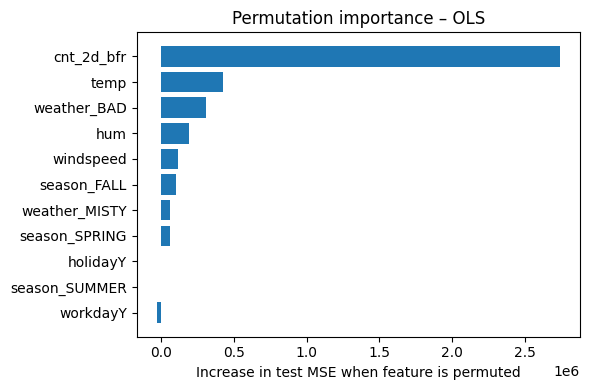

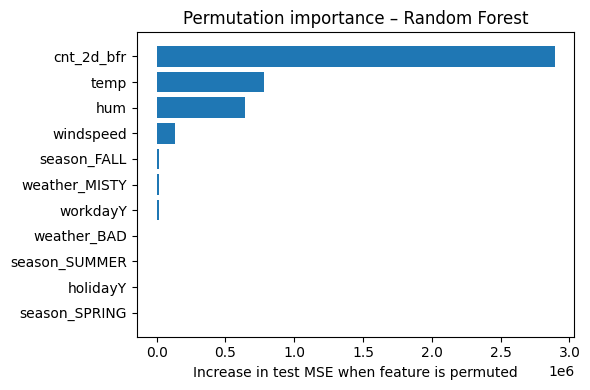

In [ ]:
def bar_plot_imp(imp_df, title):
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.barh(imp_df["feature"], imp_df["ΔMSE"])
    ax.invert_yaxis()
    ax.set_xlabel("Increase in test MSE when feature is permuted")
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

bar_plot_imp(imp_lin, "Permutation importance – OLS")
bar_plot_imp(imp_rf,  "Permutation importance – Random Forest")

## Feature importance based on mean decrease in impurity

* Impurity-based feature importances can be misleading for high cardinality features (many unique values). See Permutation feature importance as an alternative below.

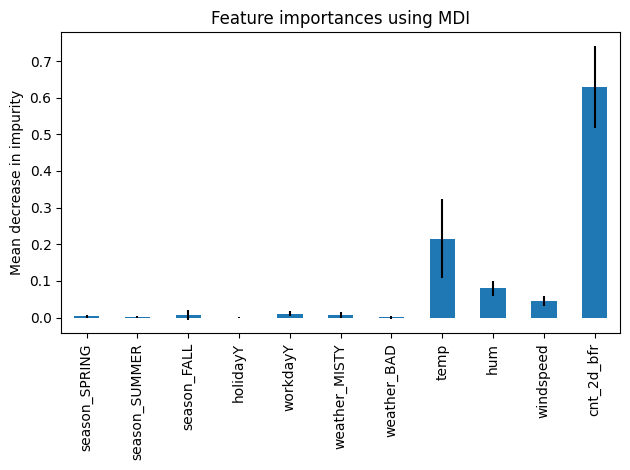

In [ ]:

importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

forest_importances = pd.Series(importances, index=X.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## Mean Decrease in Impurity (MDI) pitfalls

In [ ]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

# ------------------------------------------------------------------
# 1.  NEW toy example: y is PURE NOISE ------------------------------
#     (no feature truly predictive)
# ------------------------------------------------------------------
np.random.seed(1)
n = 10000

# Three candidate features
X_bin = np.random.randint(0, 2, size=n)          # binary, low cardinality
X_num = np.random.randn(n)                       # high‑cardinality numeric
X_cat = np.random.choice([0, 1], size=n)         # second binary

# Target is random → model SHOULD have no real signal
y = np.random.randint(0, 2, size=n)

X = pd.DataFrame({
    "bin_feat": X_bin,
    "num_noise": X_num,
    "cat_noise": X_cat
})

# ------------------------------------------------------------------
# Train/test split -------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=1, stratify=y)

# Full, unconstrained tree (to encourage over‑fit)
tree = DecisionTreeClassifier(random_state=1, min_samples_leaf=1)
tree.fit(X_train, y_train)

# ------------------------------------------------------------------
# 2. MDI (training set)
# ------------------------------------------------------------------
mdi = tree.feature_importances_

# ------------------------------------------------------------------
# 3. Permutation importance on test set
# ------------------------------------------------------------------
perm = permutation_importance(
    tree, X_test, y_test,
    n_repeats= 10000,
    random_state=1,
    scoring="accuracy"
)

delta_acc = -perm.importances_mean   # positive = accuracy drop

# ------------------------------------------------------------------
# 4. Assemble comparison table
# ------------------------------------------------------------------
table = pd.DataFrame({
    "feature": X.columns,
    "MDI": mdi.round(2),
    "ΔAccuracy (perm)": delta_acc.round(2)
}).sort_values("MDI", ascending=False).reset_index(drop=True)

table


,feature,MDI,ΔAccuracy (perm)
0,num_noise,0.96,-0.0
1,bin_feat,0.04,-0.0
2,cat_noise,0.00,0.0


# SHAP

## Linear models

In [ ]:
import pandas as pd
# Set the file URL and filename
url = 'https://archive.ics.uci.edu/ml/' \
'machine-learning-databases/' \
'wine-quality/winequality-white.csv'
file_name = '/content/XAI/wine.csv'
# Check if the file exists in the current directory
try:
  wine = pd.read_csv(file_name)
except FileNotFoundError:
  print(f'Downloading {file_name} from {url}...')
  wine = pd.read_csv(url, sep=";")
  wine.to_csv(file_name, index=False)
  print('Download complete!')

Download complete!


In [ ]:
wine

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7


In [ ]:
from tabulate import tabulate
summary = wine.describe().transpose().round(2)
print(summary)

                       count    mean    std   min     25%     50%     75%  \
fixed acidity         4898.0    6.85   0.84  3.80    6.30    6.80    7.30   
volatile acidity      4898.0    0.28   0.10  0.08    0.21    0.26    0.32   
citric acid           4898.0    0.33   0.12  0.00    0.27    0.32    0.39   
residual sugar        4898.0    6.39   5.07  0.60    1.70    5.20    9.90   
chlorides             4898.0    0.05   0.02  0.01    0.04    0.04    0.05   
free sulfur dioxide   4898.0   35.31  17.01  2.00   23.00   34.00   46.00   
total sulfur dioxide  4898.0  138.36  42.50  9.00  108.00  134.00  167.00   
density               4898.0    0.99   0.00  0.99    0.99    0.99    1.00   
pH                    4898.0    3.19   0.15  2.72    3.09    3.18    3.28   
sulphates             4898.0    0.49   0.11  0.22    0.41    0.47    0.55   
alcohol               4898.0   10.51   1.23  8.00    9.50   10.40   11.40   
quality               4898.0    5.88   0.89  3.00    5.00    6.00    6.00   

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

# Define target and features used in model
y = wine['quality']
X = wine.drop('quality', axis=1)

# Split sample into 80% for training, and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size = 0.2, random_state=42
)

# define ML and fit to the training model
model = LinearRegression()
model = model.fit(X_train, y_train)

# evaluate the OOS performance: MAE

y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae:.2f}")


**Exercise**: Evalueate the MSE for the testing set.

In [ ]:
# Examine the model coefficient
import numpy as np
coefs = pd.DataFrame({
'feature': X.columns.values,
'coefficient': np.round(model.coef_, 3)
})
print(coefs)

                 feature  coefficient
0          fixed acidity        0.046
1       volatile acidity       -1.915
2            citric acid       -0.061
3         residual sugar        0.071
4              chlorides       -0.026
5    free sulfur dioxide        0.005
6   total sulfur dioxide       -0.000
7                density     -124.264
8                     pH        0.601
9              sulphates        0.649
10               alcohol        0.229


In [ ]:
pip install shap

In [ ]:
import shap
explainer = shap.LinearExplainer(model, X_train)

In [ ]:
shap_values = explainer(X_test)
print(shap_values)

In [ ]:
# For a sample index, verify the Efficiency property
idx = 100

# Predicted value for smaple
y_pred = model.predict(X_test)
print(y_pred[idx])

# E(f(x))
print(y_pred.mean())

print(y_pred[idx]- y_pred.mean())

# sum of all shap values for smaple i
aa= shap_values.values
bb= np.sum(aa, axis= 1)
print(bb[idx])

5.600414765582727
5.893188435116176
-0.2927736695334495
-0.29004024701926756


In [ ]:
# For a sample index, verify idx_i with feature j's SHAP value equals to the \beta_j*x_j^(i)- E(x_j)

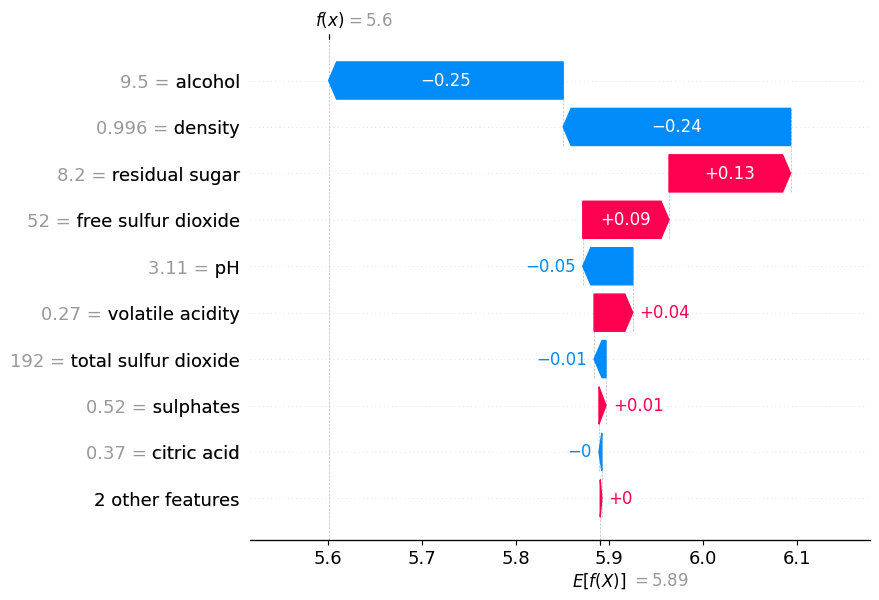

In [ ]:
#Interpreting SHAP values
shap.plots.waterfall(shap_values[idx])

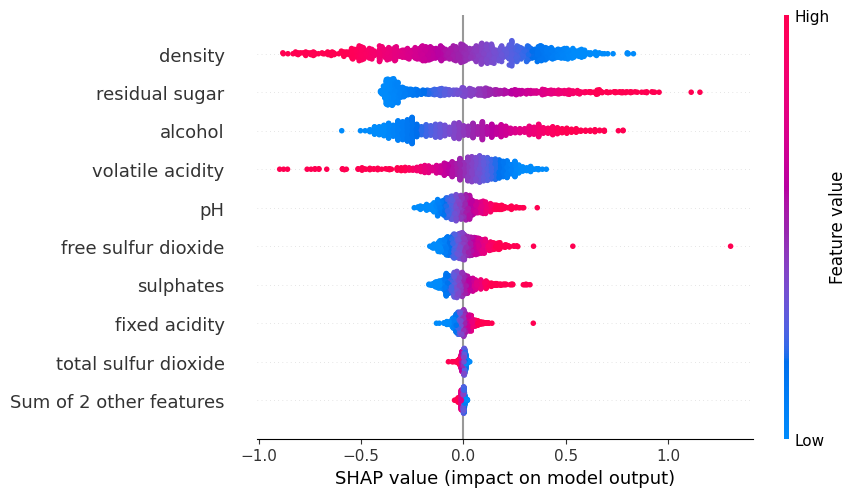

In [ ]:
# Global (Aggregration) model understanding
shap.plots.beeswarm(shap_values)



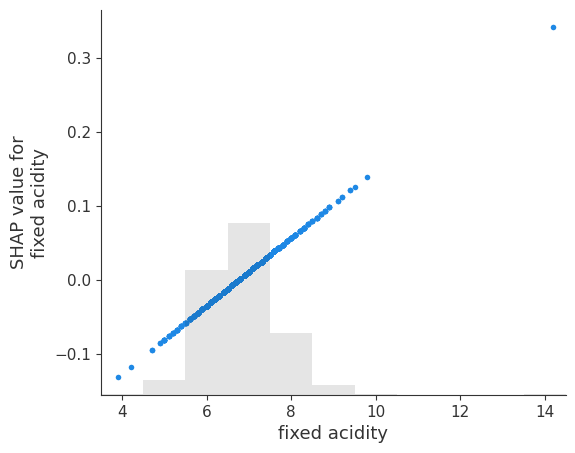

In [ ]:
shap.plots.scatter(shap_values[:, 'fixed acidity'])
#                feature  coefficient
#          fixed acidity        0.046
#       volatile acidity       -1.915
#            citric acid       -0.061
#         residual sugar        0.071
#              chlorides       -0.026
#    free sulfur dioxide        0.005
#   total sulfur dioxide       -0.000
#                density     -124.264
#                     pH        0.601
#              sulphates        0.649
#                alcohol        0.229

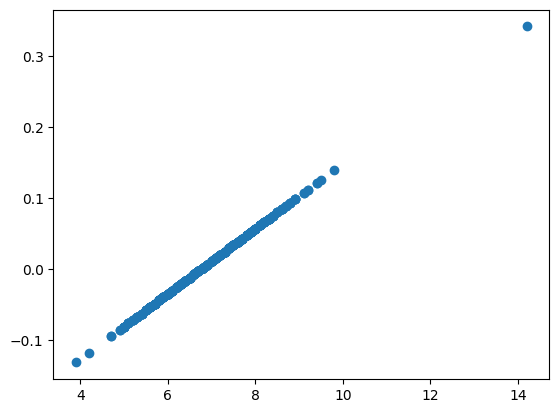

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(X_test['fixed acidity'], shap_values.values[:, 0])

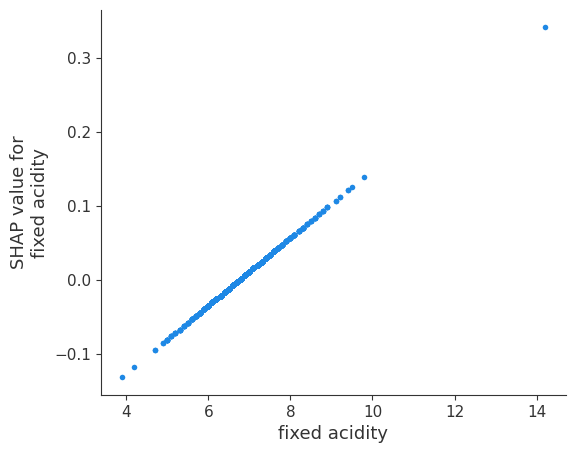

In [ ]:
shap.dependence_plot('fixed acidity', shap_values.values, X_test, interaction_index=None, show=False)

## Tree-based models

#Visualize Attention

In [ ]:
pip install bertviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.6/157.6 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 106.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 58.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from bertviz import head_view, model_view   # install with: pip install bertviz

# ── Load FinBERT ────────────────────────────────────────────────────────────
model_version = "yiyanghkust/finbert-pretrain"          # or local path
tokenizer = AutoTokenizer.from_pretrained(model_version, do_lower_case=True)
model     = AutoModelForSequenceClassification.from_pretrained(
    model_version,
    output_attentions=True
)

# ── Example sentence pair ───────────────────────────────────────────────────
sentence_a = (
    "Global macro strategies often focus on complex derivatives "
    "and systematic diversification."
)
sentence_b = (
    "Systematic and discretionary hedge funds are hard to distinguish."
)

# ── Tokenise the pair (adds [CLS] S1 [SEP] S2 [SEP]) ───────────────────────
inputs = tokenizer.encode_plus(
    sentence_a,
    sentence_b,
    add_special_tokens=True,
    return_tensors="pt"
)
input_ids     = inputs["input_ids"]       # shape: (1, seq_len)
token_type_ids = inputs["token_type_ids"] # 0 for sent‑A, 1 for sent‑B

# ── Run model *once* and grab all attentions ───────────────────────────────
with torch.no_grad():
    outputs = model(**inputs, output_attentions=True)

attentions = outputs.attentions           # tuple: (layers, 1, heads, L, L)

# ── Prepare tokens & sentence‑B start index for later use (optional) ───────
tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

# ── Visualise in BertViz (choose one) ───────────────────────────────────────
head_view(attentions, tokens)   # interactive per‑head heatmaps
# model_view(attentions, tokens)  # full model view (slower)


ModuleNotFoundError: No module named 'bertviz'

In [ ]:
model_view(attentions, tokens)

In [ ]:
head_view(attentions, tokens, layer=6, heads=[9,5])

NameError: name 'head_view' is not defined